In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from functools import reduce
import time
import matplotlib.pyplot as plt


In [2]:
def my_or(val1, val2):
    return val1 | val2

def my_and(vals):
    val = vals[0]
    for i in range(1,len(vals)):
        val = val & vals[i]
    return val
# def my_and(val1, val2):
#     return val1 & val2


def my_no(val1):
    return ~ val1


def get_keys(dict_, key):
    return [i[key] for i in dict_.values()]

In [3]:
# error_in_angle = ctrl.Antecedent(np.arange(-180, 180, 0.1), "ErrorInAngle")
# error_in_angle['n'] =          fuzz.trapmf(error_in_angle.universe, [-180,  -180,  -90, -45])
# error_in_angle['SN'] =         fuzz.trapmf(error_in_angle.universe, [ -90,  -45,  -45,   0])
# error_in_angle['Z'] =           fuzz.trapmf(error_in_angle.universe, [ -45,    0,    0,  45])
# error_in_angle['SP'] =         fuzz.trapmf(error_in_angle.universe, [   0,   45,   45,  90])
# error_in_angle['p'] =          fuzz.trapmf(error_in_angle.universe, [  45,   90,   180, 180])
# error_in_angle.view()

In [4]:
# range = ctrl.Antecedent(np.arange(0, 5, 0.1), "range")
# range['near'] =  fuzz.trapmf(range.universe, [0, 0, 1, 4])
# range['far'] =   fuzz.trapmf(range.universe, [1, 4, 5, 5])

# vel = ctrl.Consequent(np.arange(-0.02, 0.15, 0.005), "velocity")
# vel['ZV'] =     fuzz.trapmf(vel.universe, [-0.02, 0, 0.0, 0.02])
# vel['FV'] =     fuzz.trapmf(vel.universe, [0.01, 0.06, 0.10, 0.14])

# rules = [
#     ctrl.Rule(range['near'], vel['ZV']),
#     ctrl.Rule(range['far'], vel['FV'])
# ]

# x_ctrl = ctrl.ControlSystem(rules)
# xx = ctrl.ControlSystemSimulation(x_ctrl)
# xx.input['range'] = 0
# xx.compute()
# print("vel: ", xx.output['velocity'])
# vel.view(sim = xx)

In [5]:

# T(Front, Left, Right) = {N (Near); M (Мiddle); F (Far)}
# T(Rotation) = {LB (Left Big), LS (Left Small), F(Front), RS (Right Small),RB (Right Big)}
# T(Velocity) = {ZV (ZV); SV (SV); FV (FV)},

range_front = ctrl.Antecedent(np.arange(0, 5, 0.1), "front")
range_front['near'] =       fuzz.trapmf(range_front.universe, [0, 0, 1, 1.5])
range_front['middle'] =     fuzz.trapmf(range_front.universe, [1, 2, 3, 4])
range_front['far'] =        fuzz.trapmf(range_front.universe, [3.5, 4, 5, 5])
# range_front.view()

range_left = ctrl.Antecedent(np.arange(0, 2, 0.01), "left")
range_left['near'] =       fuzz.trapmf(range_left.universe, [0.0, 0.0, 0.5, 1.0])
range_left['middle'] =     fuzz.trapmf(range_left.universe, [0.5, 1.0, 1.5, 2])
range_left['far'] =        fuzz.trapmf(range_left.universe, [1.5, 2.0, 2, 2])
range_left.view()

range_right = ctrl.Antecedent(np.arange(0, 5, 0.1), "right")
range_right['near'] =       fuzz.trapmf(range_right.universe, [0, 0, 1, 1.5])
range_right['middle'] =     fuzz.trapmf(range_right.universe, [1, 2, 3, 4])
range_right['far'] =        fuzz.trapmf(range_right.universe, [3.5, 4, 5, 5])
range_right.view()

rot = ctrl.Consequent(np.arange(-0.5, 0.5, 0.01), "rotation")
rot['Left Big'] =       fuzz.trapmf(rot.universe, [-0.5, -0.5, -0.4, -0.3])
rot['Left Small'] =     fuzz.trapmf(rot.universe, [-0.4, -0.2, -0.1, -0.0])
rot['Front'] =          fuzz.trapmf(rot.universe, [-0.1,    0,    0,  0.1])
rot['Right Big'] =      fuzz.trapmf(rot.universe, [ 0.0,  0.1,  0.2,  0.4])
rot['Right Small'] =    fuzz.trapmf(rot.universe, [ 0.3,  0.4,  0.5,  0.5])
# rot.view()

vel = ctrl.Consequent(np.arange(-0.02, 0.15, 0.001), "velocity")

# vel['NV'] =     fuzz.trapmf(vel.universe, [-0.05, -0.02, -0.02, 0])
vel['ZV'] =     fuzz.trapmf(vel.universe, [-0.02, 0, 0, 0.02])
vel['SV'] =     fuzz.trapmf(vel.universe, [0.01, 0.06, 0.10, 0.14])
vel['FV'] =     fuzz.trapmf(vel.universe, [0.10, 0.15, 0.15, 0.15])
vel.view()

rules = [
    ctrl.Rule(range_front['far']                                                        , [vel['FV'], rot['Front'] ]),
    ctrl.Rule(range_front['middle'] & range_left['far']                                 , [vel['SV'], rot['Left Small'] ]),
    ctrl.Rule(range_front['near'] & range_left['far']                                   , [vel['ZV'], rot['Left Big'] ]),
    
    ctrl.Rule(range_front['middle'] & my_no(range_left['far']) & range_right['far']     , [vel['SV'], rot['Right Small'] ]),
    ctrl.Rule(range_front['near'] & my_no(range_left['far']) & range_right['far']       , [vel['ZV'], rot['Right Big'] ]),

    ctrl.Rule(range_front['middle'] & range_left['middle'] & my_no(range_right['far'])  , [vel['SV'], rot['Front'] ]),
    ctrl.Rule(range_front['near'] & range_left['middle'] & my_no(range_right['far'])    , [vel['ZV'], rot['Left Big'] ]),

    ctrl.Rule(range_front['middle'] & range_left['near'] & range_right['middle']        , [vel['SV'], rot['Front'] ]),
    ctrl.Rule(range_front['near'] & range_left['near'] & range_right['middle']          , [vel['ZV'], rot['Right Big'] ]),

    ctrl.Rule(range_front['middle'] & range_left['near'] & range_right['near']          , [vel['SV'], rot['Front'] ]),
    ctrl.Rule(range_front['near'] & range_left['near'] & range_right['near']            , [vel['ZV'], rot['Left Big'] ]),
]

x_ctrl = ctrl.ControlSystem(rules)
# x_ctrl.view()

xx = ctrl.ControlSystemSimulation(x_ctrl)

AssertionError: abcd requires the four elements                                           a <= b <= c <= d.

('vel: ', 0.08687871674491408)
('rot: ', 0.008094059405941285)


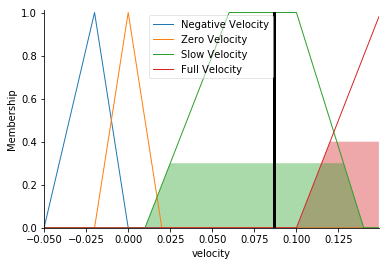

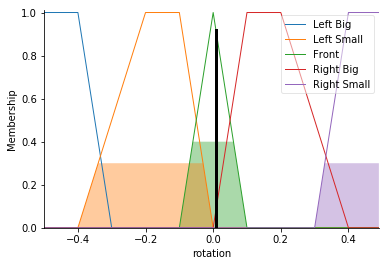

In [ ]:
xx.input['front'] = 3.7
xx.input['left'] = 3.7
xx.input['right'] = 3.7
xx.compute()
print("vel: ", xx.output['velocity'])
print("rot: ", xx.output['rotation'])
vel.view(sim = xx)
rot.view(sim = xx)

In [ ]:
a = np.array([1, 2, 3, -1, 4, 8])
print(a[0:3])
a[0:3].min()

[1 2 3]


1